In [97]:
import numpy as np
from scipy.optimize import minimize
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
import random

In [98]:
def sum_of_powers(G, n):
    """
    Compute the sum of powers of a matrix G up to the n-th power: G + G^2 + ... + G^n.
    
    Parameters:
    - G: numpy array, the matrix G.
    - n: int, the highest power to include in the sum.
    
    Returns:
    - sum_powers: numpy array, the sum of powers of G from 1 to n.
    """
    sum_powers = np.zeros_like(G)  # Initialize the sum as a zero matrix of the same shape as G
    current_power = np.copy(G)  # The current power of G, starting with G itself
    
    for i in range(1, n + 1):
        sum_powers += current_power  # Add the current power to the sum
        current_power = np.dot(current_power, G)  # Compute the next power of G
        
    return sum_powers

In [124]:
def benefit_func(G, x):
    """
    Calculates the benefit for each agent based on their own actions and the actions of their neighbors.

    Parameters:
    - G: np.array, adjacency matrix of graph of agents' connections.
    - x: np.array, vector of agents' actions.

    Returns:
    - benefits: np.array, vector of benefits for each agent.
    """
    # Calculate the total action impact for each agent, including their neighbors' influence
    action_impact = x + np.dot(G, x) * 0.5  # Assuming neighbors' actions contribute half as much to the benefit
    benefits = np.zeros_like(action_impact)
    
    for i, impact in enumerate(action_impact):
        if impact >= 0:
            benefits[i] = np.sqrt(impact)
        else:
            # Apply a linear transformation for negative values
            # This could be as simple as a direct copy, or you could scale it in some way
            # Here, we'll simply make the negative impact less detrimental by halving its effect
            benefits[i] = impact * 0.5
    
    return benefits


def cost_func(c, x):
    """
    Calculates the cost for each agent based on their actions.

    Parameters:
    - c: np.array, cost coefficient for each agent.
    - x: np.array, vector of agents' actions.

    Returns:
    - costs: np.array, vector of costs for each agent.
    """
    costs = c * x  # Linear cost function
    return costs

In [125]:
def optimal_social_actions(G, c, benefit_func, cost_func):
    """
    Calculates the socially optimal actions for agents in a game theoretic model, incorporating the benefit function.

    Parameters:
    - G: np.array, adjacency matrix of graph of agents' connections.
    - c: np.array, cost for each agent.
    - benefit_func: function, calculates the benefit for each agent based on actions and adjacency matrix.
    - cost_func: function, calculates the cost for each agent based on actions.

    Returns:
    - x_opt: np.array, vector of socially optimal actions for each agent.
    """
    
    # Number of agents
    n_agents = len(c)
    
    # Objective function to maximize: Sum of utilities across all agents
    def objective(x):
        # Calculate benefits and costs for the current action vector x
        benefits = benefit_func(G, x)
        costs = cost_func(c, x)
        
        # Calculate the total utility as the sum of benefits minus costs for each agent
        utility = sum(benefits) - sum(costs)
        
        # Since minimize is used, return the negative of the utility to maximize it
        return -utility

    # Initial guess for the actions
    x0 = np.ones(n_agents)  # Starting with a zero vector for simplicity

    # Constraints (if any, for example, actions might need to be within certain bounds)
    bounds = [(0, None) for _ in range(n_agents)]  # Assuming actions are non-negative without upper bound
    
    # Solve the optimization problem
    result = minimize(objective, x0, bounds=bounds)

    if result.success:
        x_opt = result.x
    else:
        raise ValueError("Optimization failed: " + result.message)

    return x_opt

In [126]:
def optimize_agent_action(i, x, G, c, benefit_func, cost_func):
    """
    Optimize the action of agent i to maximize their individual utility, given the actions of others,
    using the 'minimize' function for potentially unbounded optimization.

    Parameters:
    - i: int, the index of the agent whose action is being optimized.
    - x: np.array, current vector of actions for all agents.
    - G, c, benefit_func, cost_func: as previously defined.

    Returns:
    - x_i_opt: float, the optimized action for agent i.
    """
    def utility_of_i(x_i):
        # Temporarily replace the action of agent i with x_i for utility calculation
        x_new = x.copy()
        x_new[i] = x_i
        # Calculate utility as negative for minimization
        return -(benefit_func(G, x_new)[i] - cost_func(c, x_new)[i] * x_i)

    # Initial action guess for agent i
    x0 = [x[i]]
    
    # Perform the optimization without explicit bounds
    result = minimize(utility_of_i, x0)
    if result.x[0] < 0:
        return 0
    
    if result.success:
        return result.x[0]
    else:
        # raise ValueError(f"Optimization failed for agent {i} with message: {result.message}")
        return x[i]


def find_nash_equilibrium(G, c, benefit_func, cost_func, tolerance=1e-3):
    n_agents = G.shape[0]
    x_initial = np.ones(n_agents)
    x = x_initial.copy()
    iteration_difference = np.inf

    while iteration_difference > tolerance:
        x_new = x.copy()
        for i in range(n_agents):
            x_i_opt = optimize_agent_action(i, x, G, c, benefit_func, cost_func)
            x_new[i] = x_i_opt

        iteration_difference = np.linalg.norm(x_new - x)
        x = x_new.copy()

    return x

In [127]:
def create_weighted_watts_strogatz(N, k, p, weight_range=(-1, 1)):
    """
    Create a weighted Watts-Strogatz small-world network.

    Parameters:
    - N (int): Number of nodes in the graph.
    - k (int): Each node is connected to k nearest neighbors in ring topology.
    - p (float): The probability of rewiring each edge.
    - weight_range (tuple): The range (min, max) of the weights to assign to the edges.

    Returns:
    - G (networkx.Graph): A weighted Watts-Strogatz small-world network.
    """
    # Generate an unweighted Watts-Strogatz small-world graph
    G = nx.watts_strogatz_graph(N, k, p)
    
    # Assign random weights to each edge within the specified range
    for (u, v) in G.edges():
        G.edges[u,v]['weight'] = np.random.uniform(*weight_range)

    # adjacency matrix
    adj_matrix = nx.to_numpy_array(G)
    
    return adj_matrix

def create_weighted_directed_cycle_graph(N):
    """
    Create a weighted directed cycle graph with N nodes.

    Parameters:
    - N: int, the number of nodes in the graph.

    Returns:
    - nx.DiGraph: The weighted directed cycle graph.
    """
    graph = nx.DiGraph()
    nodes = list(range(N))
    graph.add_nodes_from(nodes)

    for i in range(N):
        weight = random.uniform(-1, 1)
        graph.add_edge(i, (i + 1) % N, weight=weight)

    # return the adjacency matrix
    adj_matrix = nx.to_numpy_array(graph)

    return adj_matrix

In [133]:
n = 10
# G = create_weighted_directed_cycle_graph(n)
G1 = create_weighted_directed_cycle_graph(n)
G2 = create_weighted_watts_strogatz(n, 2, 0.1)


# generate a weighted erdos renyi graph using networkx
G = nx.erdos_renyi_graph(n, 0.5, directed=True)
for (u, v) in G.edges():
    G[u][v]['weight'] = (np.random.rand()-0.5) * 2 # random weight between -1 and 1
G3 = nx.to_numpy_array(G)
G4 = (np.random.rand(n, n)-0.5)*2

c = np.ones(n)

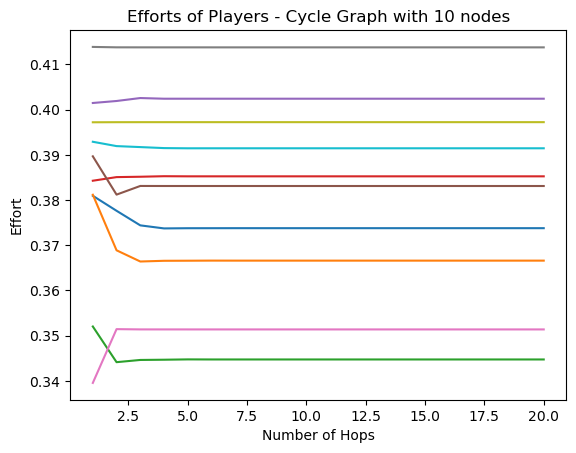

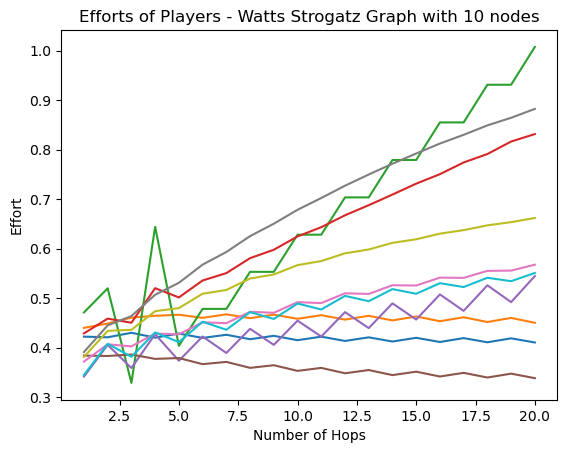

In [135]:
x_opt = optimal_social_actions(G, c, benefit_func, cost_func)
# print("Socially optimal actions:", x_opt)
max_hops = 20

x_nash_list1 = []
for hops in range(1, max_hops + 1):
    x_nash = find_nash_equilibrium(sum_of_powers(G1, hops), c, benefit_func, cost_func)
    x_nash_list1.append(x_nash)
# plot the efforts of each player over hops
plt.figure()
for i in range(n):
    plt.plot(range(1, max_hops + 1), [x_nash[i] for x_nash in x_nash_list1], label=f'Player {i}')
    # plt.plot(range(1, max_hops + 1), [x_opt[i]] * max_hops, label=f'Player {i} (optimal)', linestyle='--')
plt.xlabel("Number of Hops")
plt.ylabel("Effort")
plt.title(f"Efforts of Players - Cycle Graph with {n} nodes")# plt.legend()
plt.show()



x_nash_list2 = []
for hops in range(1, max_hops + 1):
    x_nash = find_nash_equilibrium(sum_of_powers(G2, hops), c, benefit_func, cost_func)
    x_nash_list2.append(x_nash)
# plot the efforts of each player over hops
plt.figure()
for i in range(n):
    plt.plot(range(1, max_hops + 1), [x_nash[i] for x_nash in x_nash_list2], label=f'Player {i}')
    # plt.plot(range(1, max_hops + 1), [x_opt[i]] * max_hops, label=f'Player {i} (optimal)', linestyle='--')
plt.xlabel("Number of Hops")
plt.ylabel("Effort")
plt.title(f"Efforts of Players - Watts Strogatz Graph with {n} nodes")# plt.legend()
plt.show()



# x_nash_list3 = []
# max_hops = 10
# for hops in range(1, max_hops + 1):
#     x_nash = find_nash_equilibrium(sum_of_powers(G3, hops), c, benefit_func, cost_func)
#     x_nash_list3.append(x_nash)
# # plot the efforts of each player over hops
# plt.figure()
# for i in range(n):
#     plt.plot(range(1, max_hops + 1), [x_nash[i] for x_nash in x_nash_list3], label=f'Player {i}')
#     # plt.plot(range(1, max_hops + 1), [x_opt[i]] * max_hops, label=f'Player {i} (optimal)', linestyle='--')
# plt.xlabel("Number of Hops")
# plt.ylabel("Effort")
# plt.title(f"Efforts of Players - Erdos Renyi Graph with {n} nodes")# plt.legend()
# plt.show()



# x_nash_list4 = []
# max_hops = 10
# for hops in range(1, max_hops + 1):
#     x_nash = find_nash_equilibrium(sum_of_powers(G4, hops), c, benefit_func, cost_func)
#     x_nash_list4.append(x_nash)
# # plot the efforts of each player over hops
# plt.figure()
# for i in range(n):
#     plt.plot(range(1, max_hops + 1), [x_nash[i] for x_nash in x_nash_list4], label=f'Player {i}')
#     # plt.plot(range(1, max_hops + 1), [x_opt[i]] * max_hops, label=f'Player {i} (optimal)', linestyle='--')
# plt.xlabel("Number of Hops")
# plt.ylabel("Effort")
# plt.title(f"Efforts of Players - Random Graph with {n} nodes")# plt.legend()
# plt.show()
